# 100hz Model evaluation

### Imports

In [2]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import os
import scipy.io as sio
import xgboost as xgb

### IO data cleaning

**This is a very intricate function and should be used with caution**
* This function goes through each .hea file and deletes the .mat extension that was causing errors in the reading.

In [3]:
folder_path = "../data/WFDB/"
# Loops thorugh the .hea files and re formats them according to WFDB standards. This dataset included a .mat file type at the end and thew an error. 
# This loop modifies the .hea files by only removing the .mat text if its found on the line. 

for filename in os.listdir(folder_path):
    if filename.endswith(".hea"):
        file_path = os.path.join(folder_path, filename)
        
        # Read the contents of the .hea file
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # Adjust and format the header lines to remove ".mat" at the end
        adjusted_lines = []
        for line in lines:
            adjusted_line = line.replace(".mat", "")
            adjusted_lines.append(adjusted_line)
        
        # Write the adjusted lines back to the .hea file
        with open(file_path, 'w') as file:
            file.writelines(adjusted_lines)

### Data Loading
* Mat loader: Loads the .mat files independently. Only keeps ecgs with shape (12, 5000) to prevent data mismatch.
* Header Loader: Loads .hea files independently. Uses the wfdb rdheader function to produce a dictionary. 
* Joint function: Loads both the .mat and corresponding header file given that the mat file is of shape (12, 5000)

In [4]:
import os
import numpy as np
import wfdb
import tensorflow as tf
import traceback

folder_path = "../data/WFDB/"

def wfdb_mat_load(path):
    data = []
    for filename in os.listdir(path):
        if filename.endswith(".mat"):
            record_data = sio.loadmat(os.path.join(path, filename))
            if(record_data['val'].shape == (12,5000)):
                data.append(np.array(record_data['val']))
    return data


def wfdb_hea_load(path):
    hea_files = []
    for filename in os.listdir(path):
        if filename.endswith(".hea"):
            base_name, file_type = os.path.splitext(filename)
            file_path = os.path.join(path, base_name)
            header = wfdb.rdheader(path+base_name)
            hea_files.append(header)
    return hea_files

# Incorporates both loading functions so that any data excluded from X is removed from the corresponding Y.
def wfdb_loader(path):
    data = []    
    hea_files = []
    for filename in os.listdir(path):
        if filename.endswith(".mat"):
            record_data = sio.loadmat(os.path.join(path, filename)) # First handles the .mat file
            if record_data['val'].shape == (12, 5000):
                data.append(np.array(record_data['val']))
                header = wfdb.rdheader(path + filename.split(".")[0]) # Switches to .hea file
                hea_files.append(header)
    
    return (tf.cast(tf.transpose(np.array(data), perm=[0, 2, 1])
, dtype=tf.float64)/500), hea_files


sampling_rate = 100

# Load raw signal data
with tf.device('/CPU:0'):
    X_nan, Y_raw = wfdb_loader(folder_path)


#### Raw outputs
* Packaged in Record data types
    * Requires further parsing

In [5]:
Y_raw[0:5], Y_raw[0].comments

([<wfdb.io.record.Record at 0x24aa7200d00>,
 ['Age: NaN',
  'Sex: Female',
  'Dx: 426783006',
  'Rx: Unknown',
  'Hx: Unknown',
  'Sx: Unknown'])

### Further Data Processing

Converts the raw header data into a Pandas Dataframe. Becomes usable in the form of columns.

In [6]:
Y_nan = []
for hea in Y_raw:
    metadata = {}
    for line in hea.comments[0:]:
        key, value = line.strip("#").split(":")
        metadata[key.strip()] = value.strip()
    Y_nan.append(metadata)

Y_nan = pd.DataFrame(Y_nan)
Y_nan

,Age,Sex,Dx,Rx,Hx,Sx
0,NaN,Female,426783006,Unknown,Unknown,Unknown
1,NaN,Female,426783006,Unknown,Unknown,Unknown
2,NaN,Male,426783006,Unknown,Unknown,Unknown
3,75,Male,"426177001,425623009,164934002,164873001",Unknown,Unknown,Unknown
4,83,Male,"59118001,164889003",Unknown,Unknown,Unknown
...,...,...,...,...,...,...
10287,51,Male,426177001,Unknown,Unknown,Unknown
10288,67,Male,"428417006,426177001",Unknown,Unknown,Unknown
10289,74,Male,"426177001,427393009",Unknown,Unknown,Unknown
10290,48,Female,"445118002,426177001,164934002,164873001",Unknown,Unknown,Unknown


#### Filtering
* Excludes NaN values in the age columns.
* Only keeps ecgs under age 89

In [7]:
with tf.device("/CPU:0"):
    Y_temp = (Y_nan[Y_nan.Age.values != 'NaN'])
    valid_inds = Y_temp.Age.values.astype(int) < 89
    Y = Y_temp[valid_inds]
    X = (X_nan[Y_nan.Age.values != 'NaN'])[valid_inds]

Y.shape, X.shape

((10101, 6), TensorShape([10101, 5000, 12]))

### Downsampling
* The raw ecg data is sampled at 500hz.
* There is a way to preserve curcial information from the ecg while reducing the samplig rate. 
* Scipy signal resampling function

In [8]:
from scipy import signal
with tf.device('/CPU:0'):
    resamp_ratio = 100/500
    X_downsampled = signal.resample(X, 1000, axis=1)

X_downsampled.shape

(10101, 1000, 12)

### Data Augmentation
* We must apply the same transformations as we did on the original dataset

In [9]:
import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [10]:
with tf.device('/CPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best

    X_final = da_apply(X_downsampled, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

#### Data visualization

Text(0.5, 1.0, 'Distribution of Age')

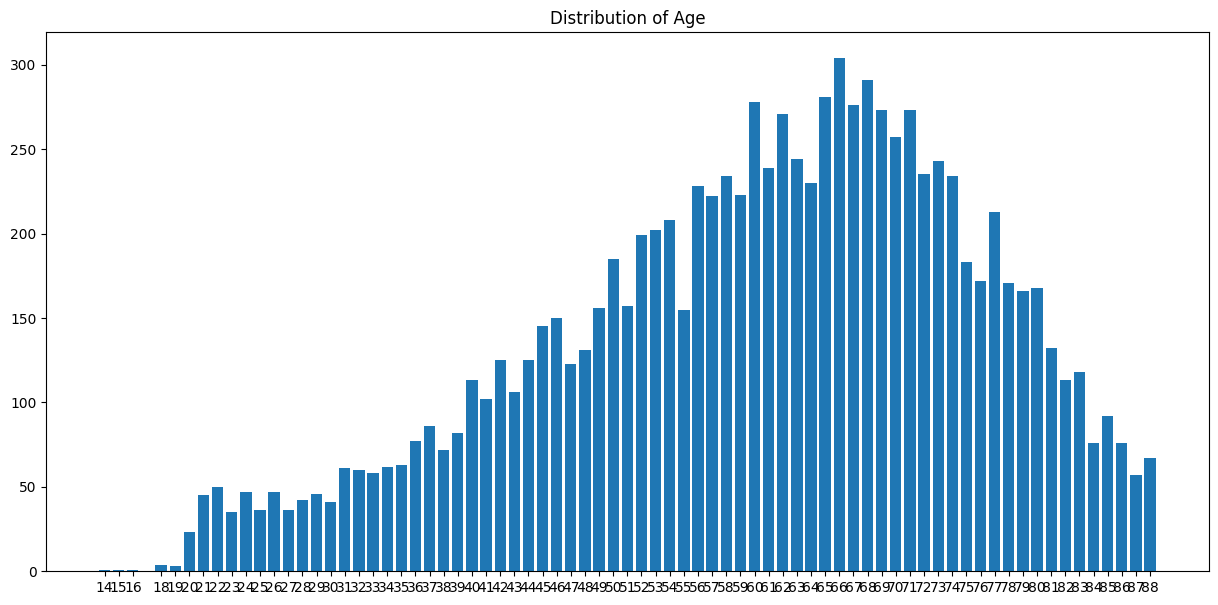

In [11]:
y_age_demo = Y[Y.Age.values.astype(int) < 89].Age.values.astype(int)
uniques, counts = np.unique(pd.DataFrame(y_age_demo), return_counts=True)
plt.figure(figsize=(15,7))
plt.bar(uniques, counts)
plt.xticks(uniques, rotation = 0)
plt.title("Distribution of Age")

### Loading the Model

In [12]:
cnn_age_model = tf.keras.models.load_model("../saved_models/100hz/age_models/model_1.h5")
rnn_sex_model = tf.keras.models.load_model("../saved_models/100hz/sex_models/rnn_sex_model_0.8310.h5")
cnn_sex_model = tf.keras.models.load_model("../saved_models/100hz/sex_models/model_1.h5")
cnn_lstm_model = tf.keras.models.load_model('../saved_models/100hz/age_models/cnn_rnn_age_model_0.855')

updated_cnn_age_model = tf.keras.models.load_model("../saved_models/100hz/age_models/updated_model.h5", compile = False)
cnn_age_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                      loss = 'mean_absolute_error',
                      metrics=['mae'])

In [13]:
def create_actuals(Y):
    actual_ages = Y.Age.values.astype(int)
    actual_sex = Y.Sex.values
    actual_sex[actual_sex == 'Male'] = 0
    actual_sex[actual_sex == 'Female'] = 1
    actual_sex = actual_sex.astype(int)
    return actual_ages, actual_sex

actual_ages, actual_sex = create_actuals(Y)

### XGBoost

### Classification Boost

In [14]:
def apply_boost_classification(model, layer_name, X, y):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)


    # Extracting the features from the LSTM layer
    X_features = feature_extraction_model.predict(X) 

    # XGBoost picks off from these layers and applies its own algorithm
    xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1) 
    xgb_model.fit(X_features, y) 

    xgb_probs = xgb_model.predict_proba(X_features)[:, 1]
    model_probs = rnn_sex_model.predict(X)[:, 0]

    # I am taking the average of the prediction probabilities to get a balanced result
    combined_probs = xgb_probs
    combined_preds = np.where((np.squeeze(np.where(combined_probs >= 0.50, 1, 0))) == 1, 1, 0)

    # Returning both the probabilities and predictions
    return combined_probs, combined_preds

### Regression Boost

In [15]:
# rnn_sex_model = tf.keras.models.load_model("../saved_models/100hz/sex_models/rnn_sex_model_0.8310.h5")

def apply_boost_regression(model, layer_name, X, y):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Extracting the features from the LSTM layer
    X_features = feature_extraction_model.predict(X)

    # XGBoost for regression
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model.fit(X_features, y)

    xgb_preds = xgb_model.predict(X_features)
    model_preds = model.predict(X)
    
    # Combine the predictions using some kind of average or weighting
    combined_preds = (xgb_preds + model_preds) / 2.0

    # Returning the combined regression predictions
    return xgb_preds

### Model Choice

In [16]:
with tf.device('/CPU:0'):
    combined_sex_probs, combined_sex_preds = apply_boost_classification(rnn_sex_model, 'lstm_64', X_final, actual_sex)
    combined_age_pred = apply_boost_regression(cnn_lstm_model, 'flatten', X_final, tf.cast(actual_ages, dtype=tf.int32))

316/316 [==============================] - 3s 6ms/step


### Predictions

In [17]:
def predict_sex(model, X):
    temp = model(tf.convert_to_tensor(X))
    predicted_sex_prob = np.asarray(tf.squeeze(temp))
    predicted_sex = np.where((np.squeeze(np.where(predicted_sex_prob >= 0.50, 1, 0))) == 1, 1, 0)
    return predicted_sex_prob, predicted_sex


def predict_age(model, X):
    temp = model(tf.convert_to_tensor(X))
    predicted_age = np.asarray(tf.squeeze(temp))
    return predicted_age

In [18]:
with tf.device('/CPU:0'):
    predicted_age = predict_age(cnn_age_model, X_final)
    predicted_sex_prob, predicted_sex = predict_sex(cnn_sex_model, X_final)

### Binning

In [19]:
# Function to bin the age values into age blocks
def bin_age(age):
    if age <18:
        return '<18'
    elif age >= 18 and age <= 25:
        return '18-25'
    elif age > 25 and age <= 49:
        return '25-49'
    elif age > 49 and age <= 75:
        return '50-75'
    else:
        return '75+'


### Evaluation Metrics

#### Mean Squared Error for Age
* Suboptimal but decent mae for a completely blind dataset

In [20]:
from sklearn.metrics import mean_absolute_error,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

mean_absolute_error(actual_ages, predicted_age), mean_absolute_error(actual_ages, combined_age_pred)

(11.104365237313159, 6.835094870535316)

#### Accuracy For Sex
* Similar to the sex model, the accuracy of the sex model on a completely blind dataset with over 10k samples is rather decent.

In [21]:
accuracy_score(actual_sex, predicted_sex), accuracy_score(actual_sex, combined_sex_preds)

(0.6966636966636967, 0.841005841005841)

### AUC for Sex prediction

In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(actual_sex, predicted_sex_prob), roc_auc_score(actual_sex, combined_sex_probs)

(0.7998623509785314, 0.9310105542620973)

### R-Squared for Age Prediction

In [23]:
from sklearn.metrics import r2_score
r2_score(actual_ages, predicted_age), r2_score(actual_ages, combined_age_pred)

(0.10089647088377485, 0.6766719128760249)

### F-1 Sex

In [24]:
from sklearn.metrics import f1_score
f1_score(actual_sex, predicted_sex), f1_score(actual_sex, combined_sex_preds)

(0.7210995812852722, 0.8279777206512424)

### F1 for Age

In [25]:
# Assuming y_test contains the actual age values and y_pred contains the predicted age values
# Create the actual age blocks
y_test_blocks = np.array([bin_age(age) for age in actual_ages])

# Create the predicted age blocks
y_pred_blocks = np.array([bin_age(age) for age in combined_age_pred])

f1_score(y_test_blocks, y_pred_blocks, average = 'micro')

0.7158697158697157

In [26]:
import seaborn as sns   # Remeber to install seaborn

def age_bar(actual, predicted, title):
    # Create a DataFrame from the data
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})  # Merges the Actual and predicted data

    # Create a group boxplot using seaborn
    plt.figure(figsize=(25, 10))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    sns.boxplot(x='Category', y='Values', data=data, width=0.6)   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced
    category_positions = range(len(data['Category'].unique()))
    plt.scatter(category_positions, np.unique(np.squeeze(actual)), color='black', label='Scatter Plot', alpha = 0.7)   # The true line represents what the predicted age should be. 
    plt.xlabel('Actual Age', fontsize = 18)
    plt.ylabel('Predicted Age', fontsize = 18)
    plt.xticks(fontsize=11) 
    plt.yticks(range(0, 135, 5), fontsize=11)
    plt.title(title, fontsize = 21)
    plt.show()

In [27]:
def category_boxplot(categories, values, title, xlabel='Age Group', ylabel='Age Predictions', category_order=None):
    data = pd.DataFrame({xlabel: categories, ylabel: values})
    
    if category_order:
        data[xlabel] = pd.Categorical(data[xlabel], categories=category_order, ordered=True)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=xlabel, y=ylabel, data=data, width=0.6, order=category_order)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize =20)

    # Show the plot
    plt.show()

In [28]:
import seaborn as sns   # Remeber to install seaborn

def cat_plot(actual, predicted):
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})  # Merges the Actual and predicted data
    sns.catplot(x='Category', y='Values', data=data, order=['18-25', '25-49', '50-75', '75+'])   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced



In [29]:
def age_categorizer(actual, predicted, Y, title, category_column):
    unique_categories = Y[category_column].unique()

    for category_value in unique_categories:
        predicted_category = predicted[Y[category_column] == category_value]
        actual_category = actual[Y[category_column] == category_value]

        age_bar(actual_category, predicted_category, title=f'{title} - {category_value}')

In [30]:
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

def make_confusion_matrix(y_actual, y_pred, classes=None, figsize=(10, 10), text_size=15):
    cm = confusion_matrix(y_actual, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    labels = classes if classes else np.arange(cm.shape[0])
    ax.set(title="Confusion Matrix On Testing Dataset",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ax.set_xlabel("Predicted label", fontsize=text_size)
    ax.set_ylabel("True label", fontsize=text_size)
    ax.set_title("Confusion Matrix", fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), repeat=2):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

    plt.show()


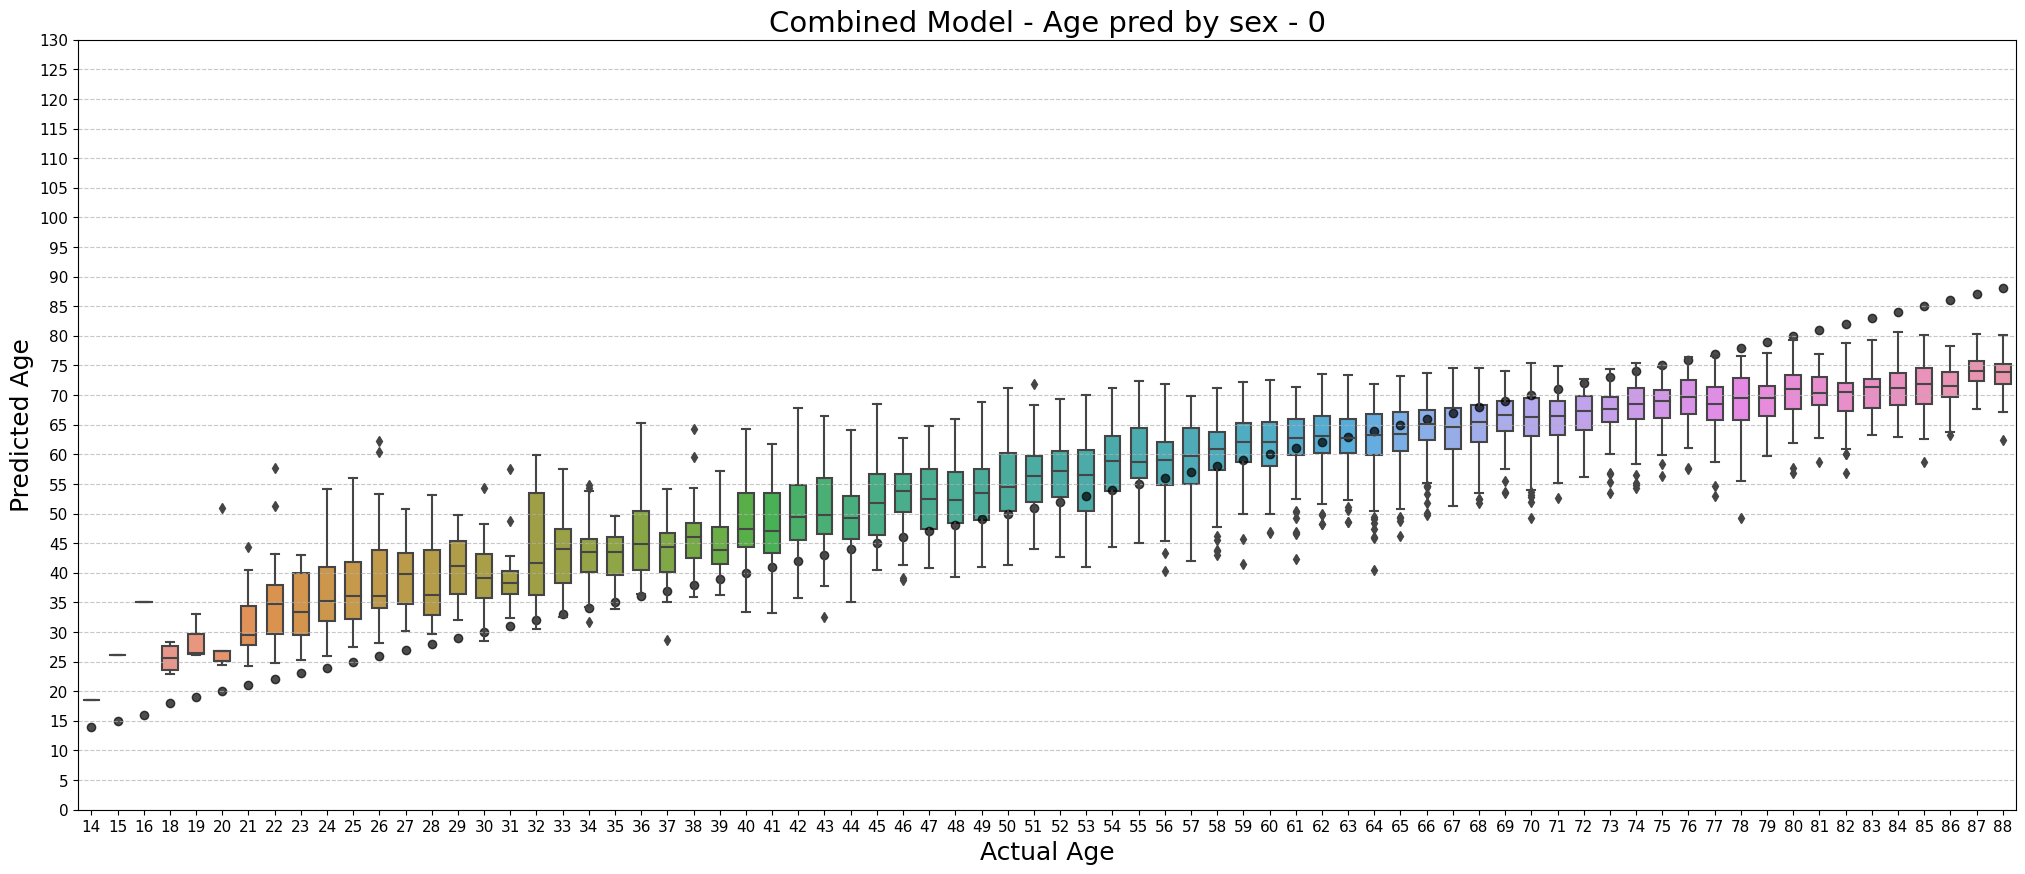

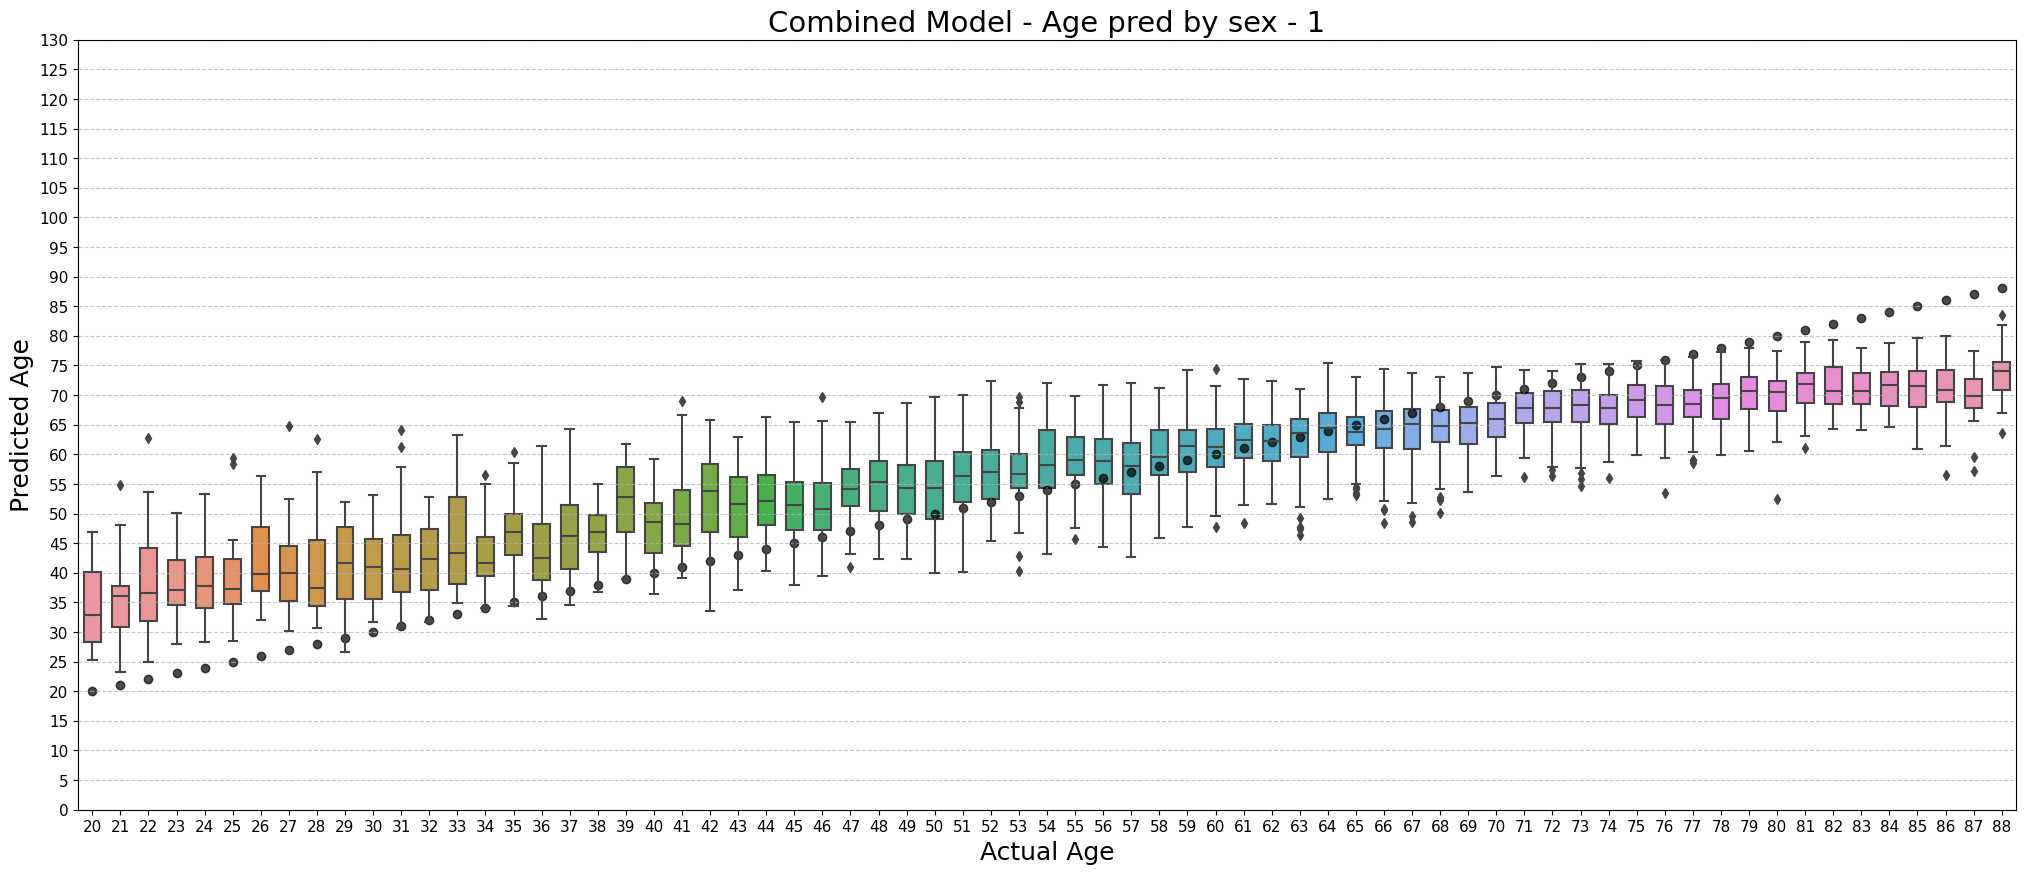

In [31]:
age_categorizer(actual_ages, combined_age_pred, Y, title = "Combined Model - Age pred by sex", category_column = 'Sex' )

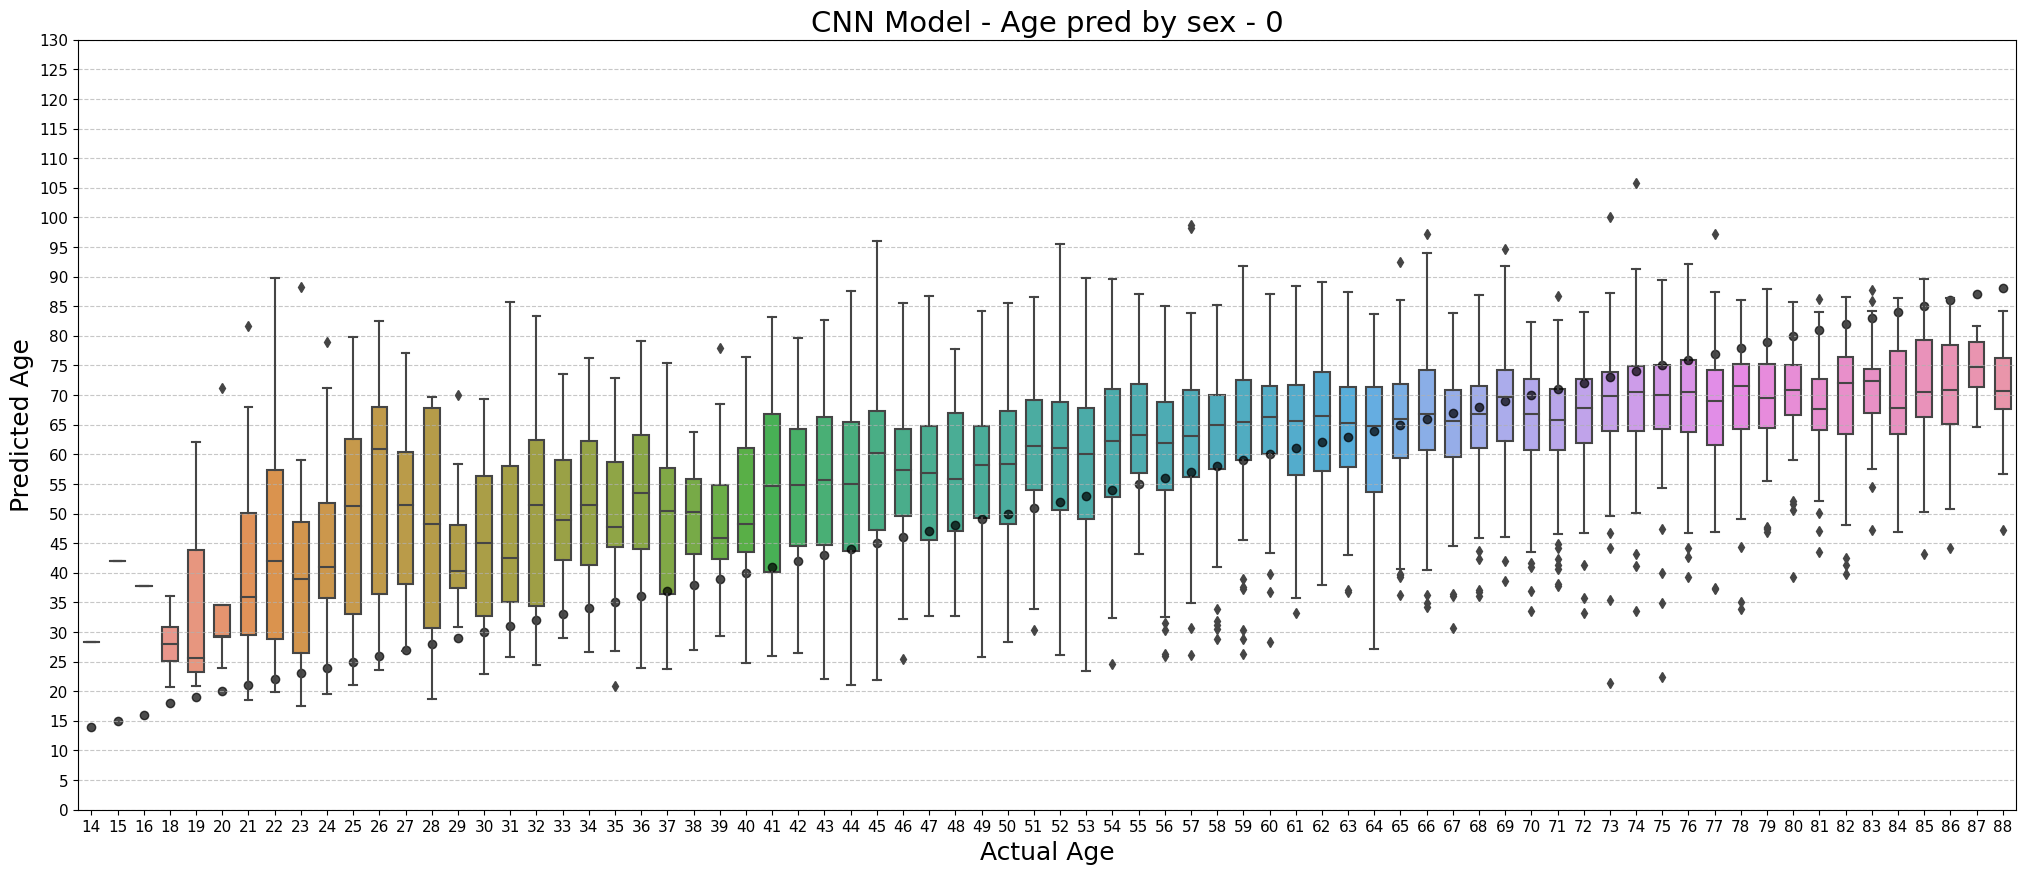

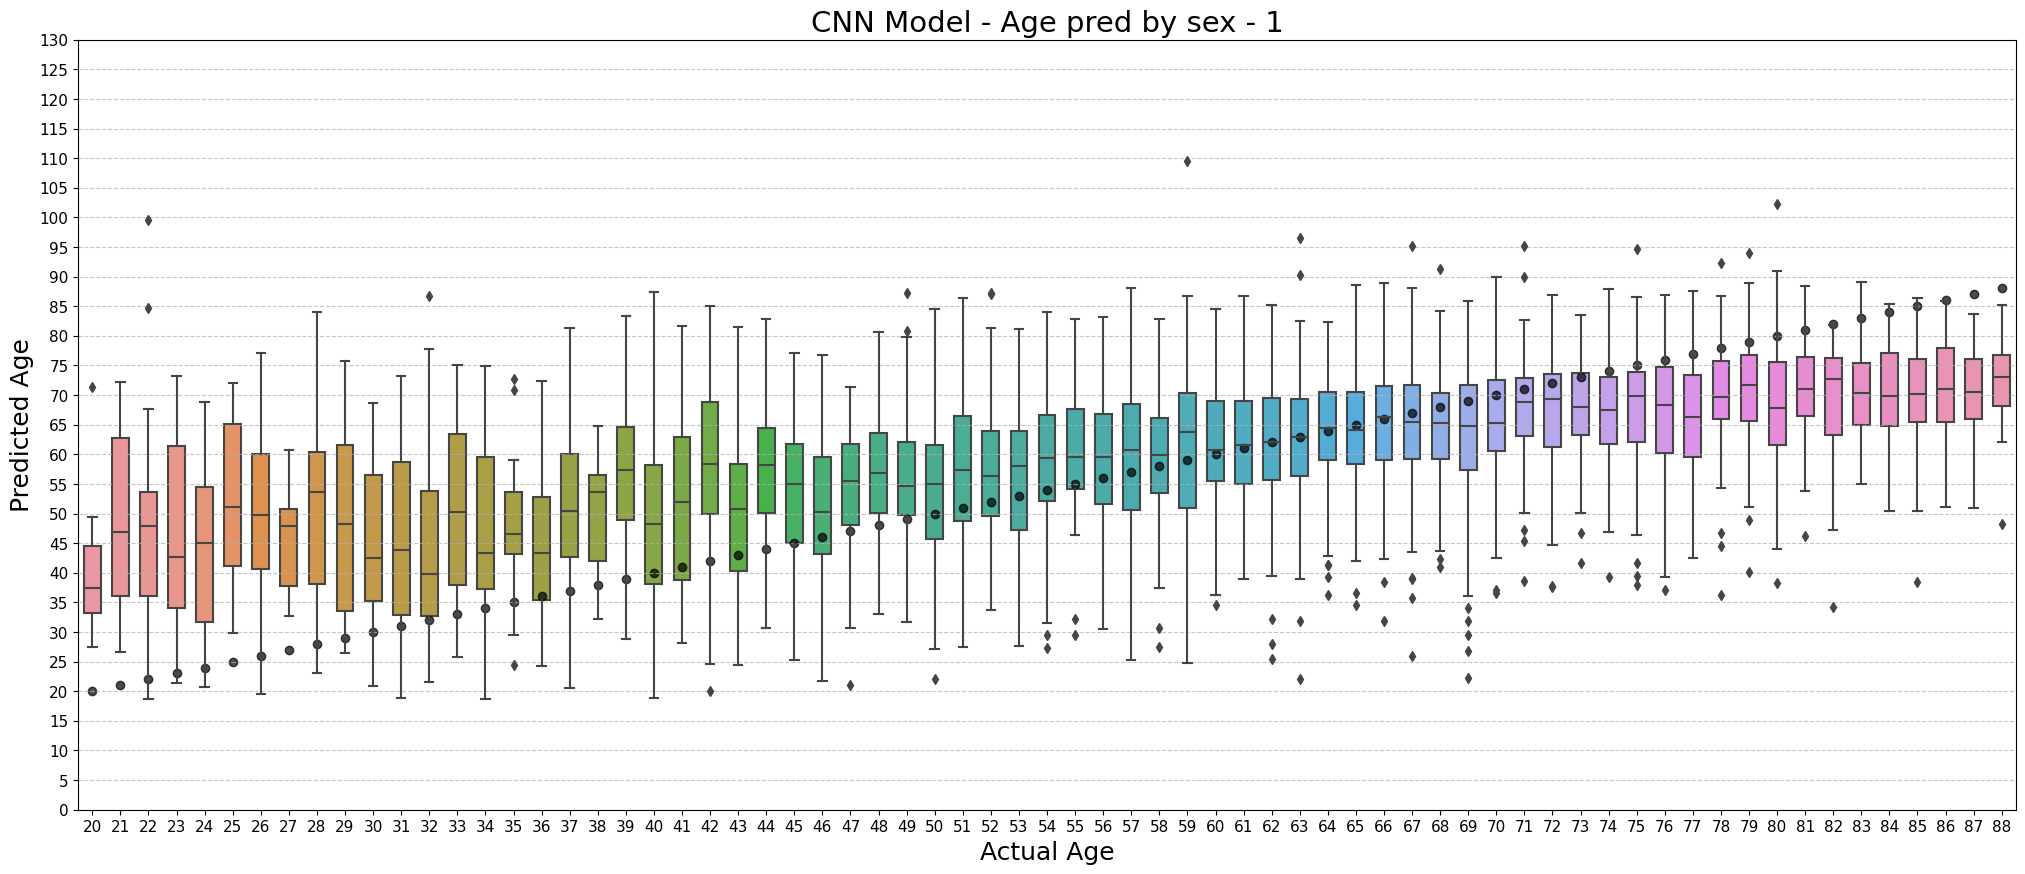

In [32]:
age_categorizer(actual_ages, predicted_age, Y, title = "CNN Model - Age pred by sex", category_column = 'Sex' )

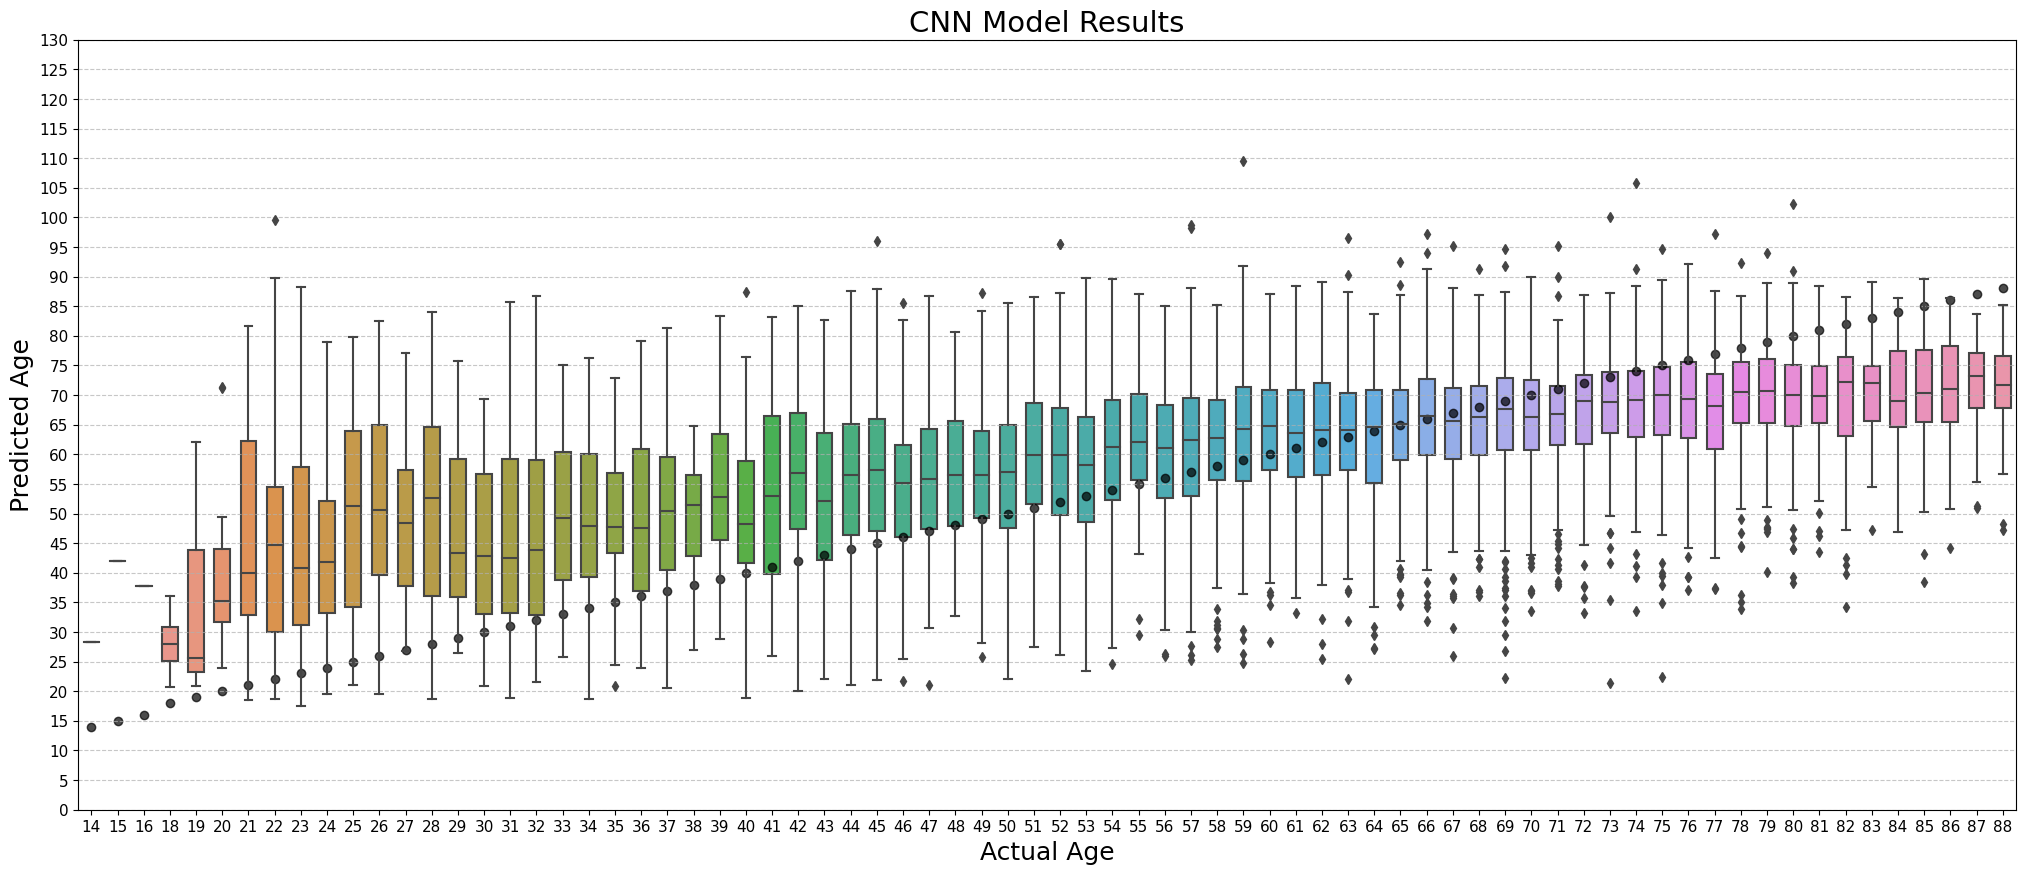

In [33]:
age_bar(actual_ages, predicted_age, title = "CNN Model Results")

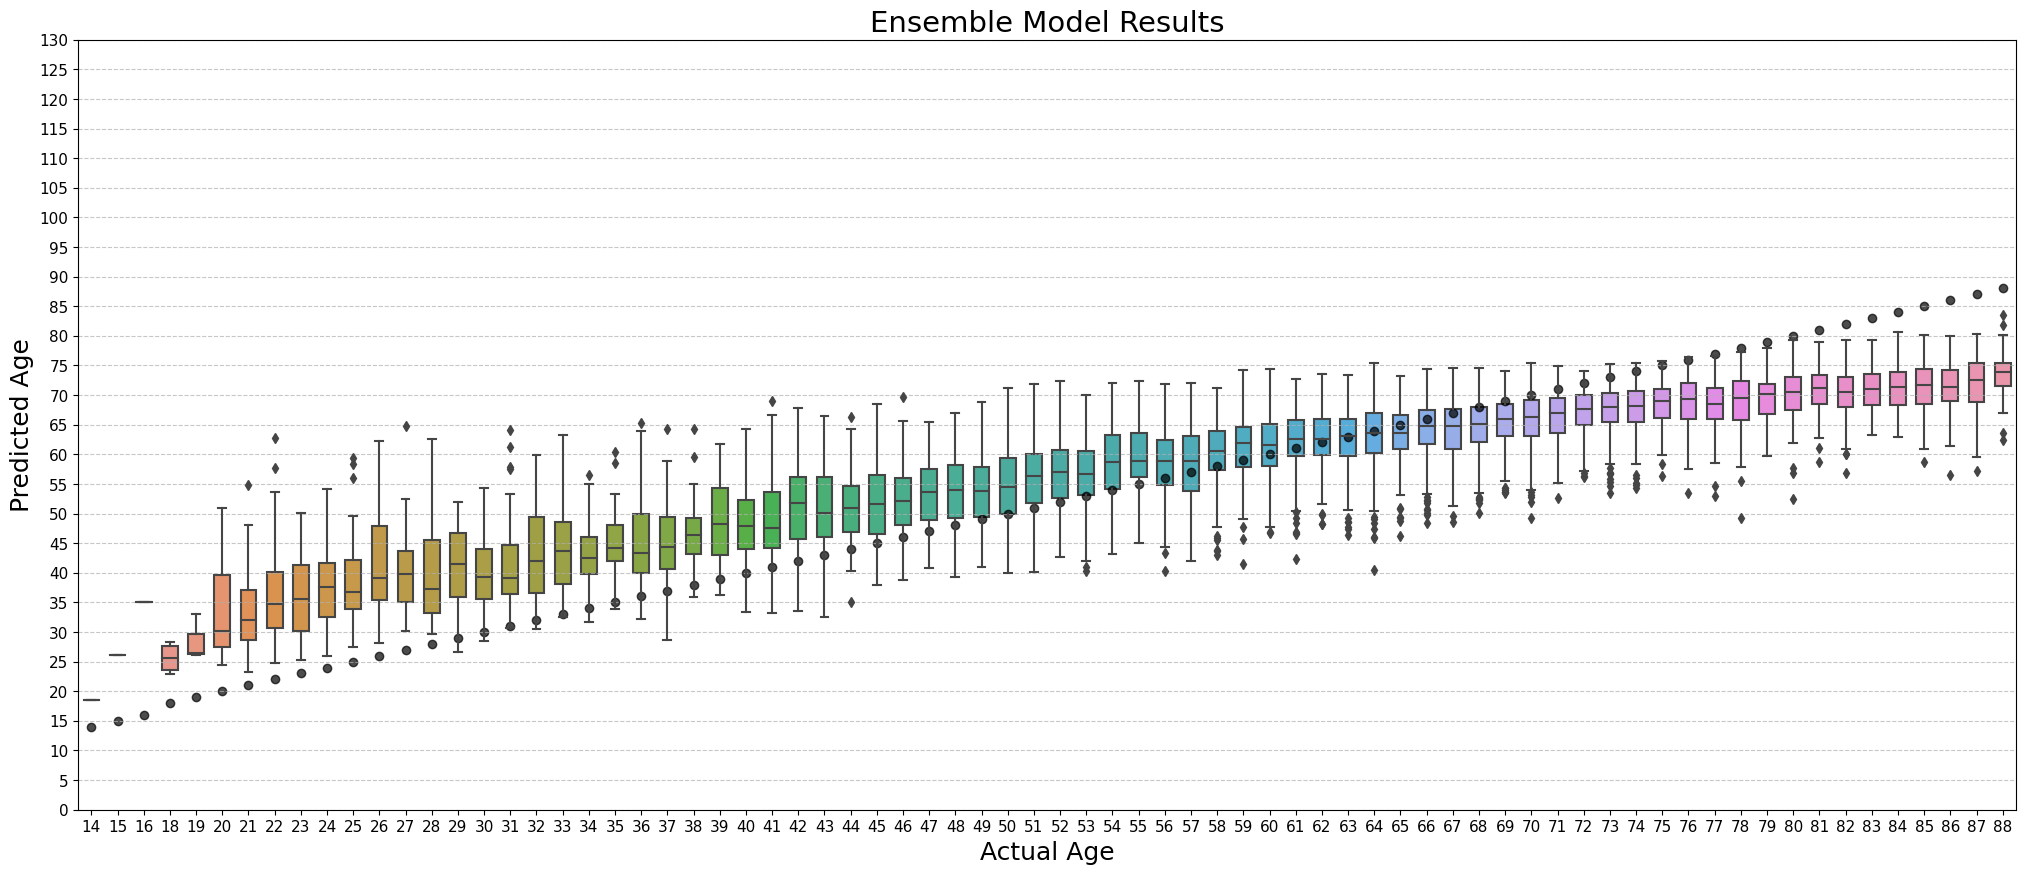

In [34]:
age_bar(actual_ages, combined_age_pred, title = "Ensemble Model Results")

In [35]:
count = 0
for i in y_test_blocks:
    if i == '50-75':
        count = count + 1
print(count)

6125


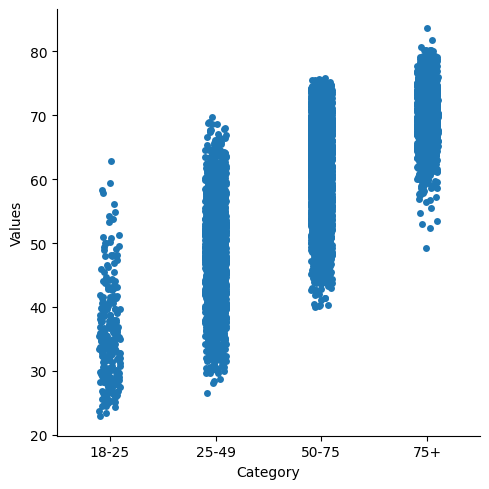

In [36]:
cat_plot(y_test_blocks, combined_age_pred)

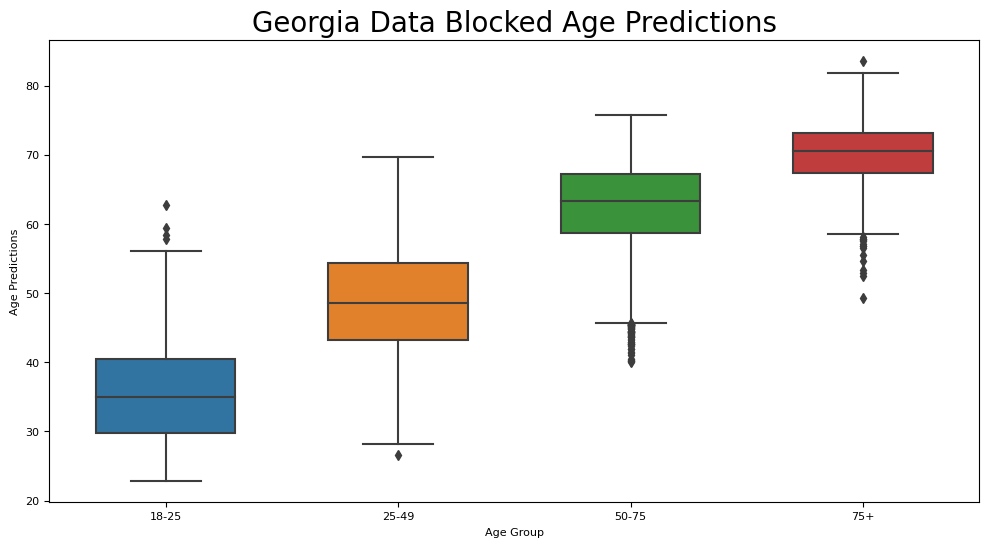

In [44]:
category_boxplot(y_test_blocks, combined_age_pred, title = "Georgia Data Blocked Age Predictions", category_order = ['18-25', '25-49', '50-75', '75+'])

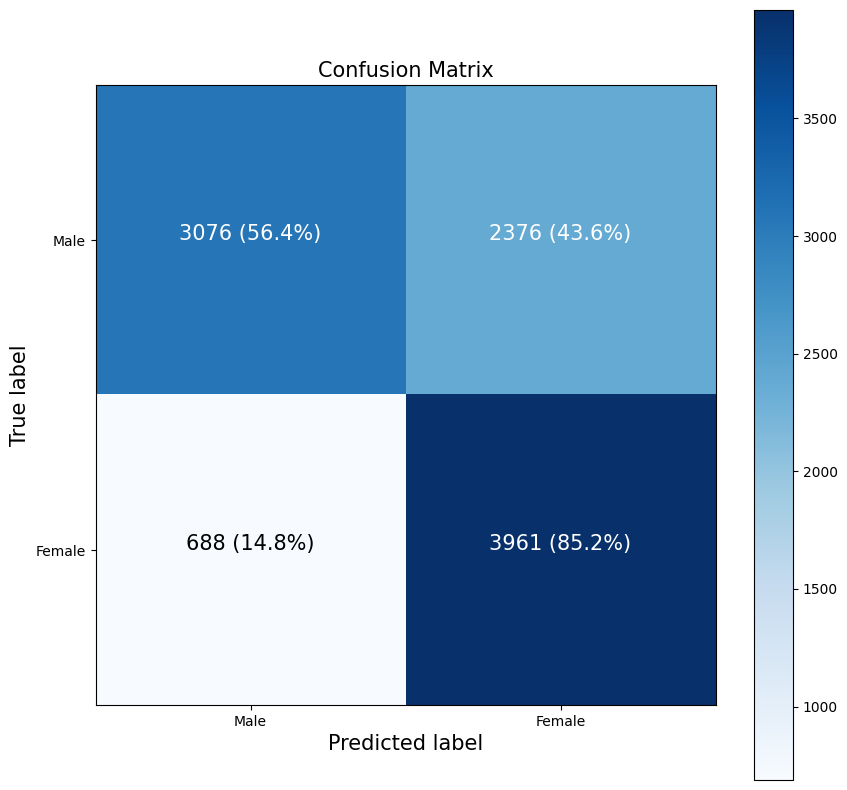

In [38]:
class_name = ['Male', 'Female']
make_confusion_matrix(actual_sex, predicted_sex, class_name)

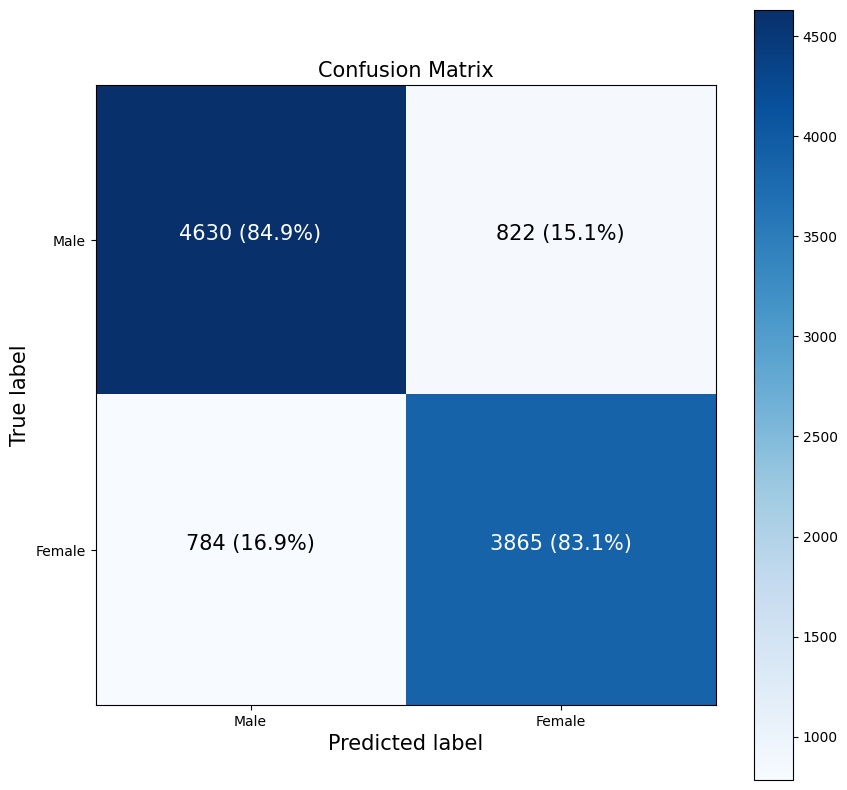

In [39]:
make_confusion_matrix(actual_sex, combined_sex_preds, class_name)

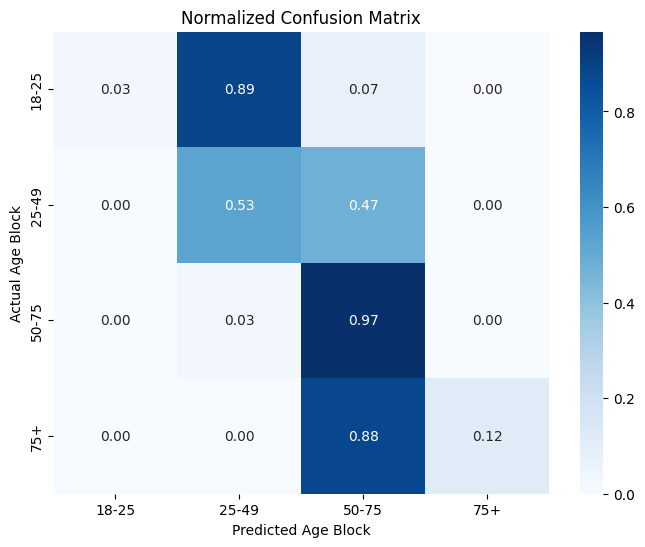

In [40]:

# Compute the confusion matrix
cm = confusion_matrix(y_test_blocks, y_pred_blocks, labels=['18-25', '25-49', '50-75', '75+'])

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['18-25', '25-49', '50-75', '75+'], yticklabels=['18-25', '25-49', '50-75', '75+'])
plt.xlabel('Predicted Age Block')
plt.ylabel('Actual Age Block')
plt.title('Normalized Confusion Matrix')
plt.show()


#### Sampling examples

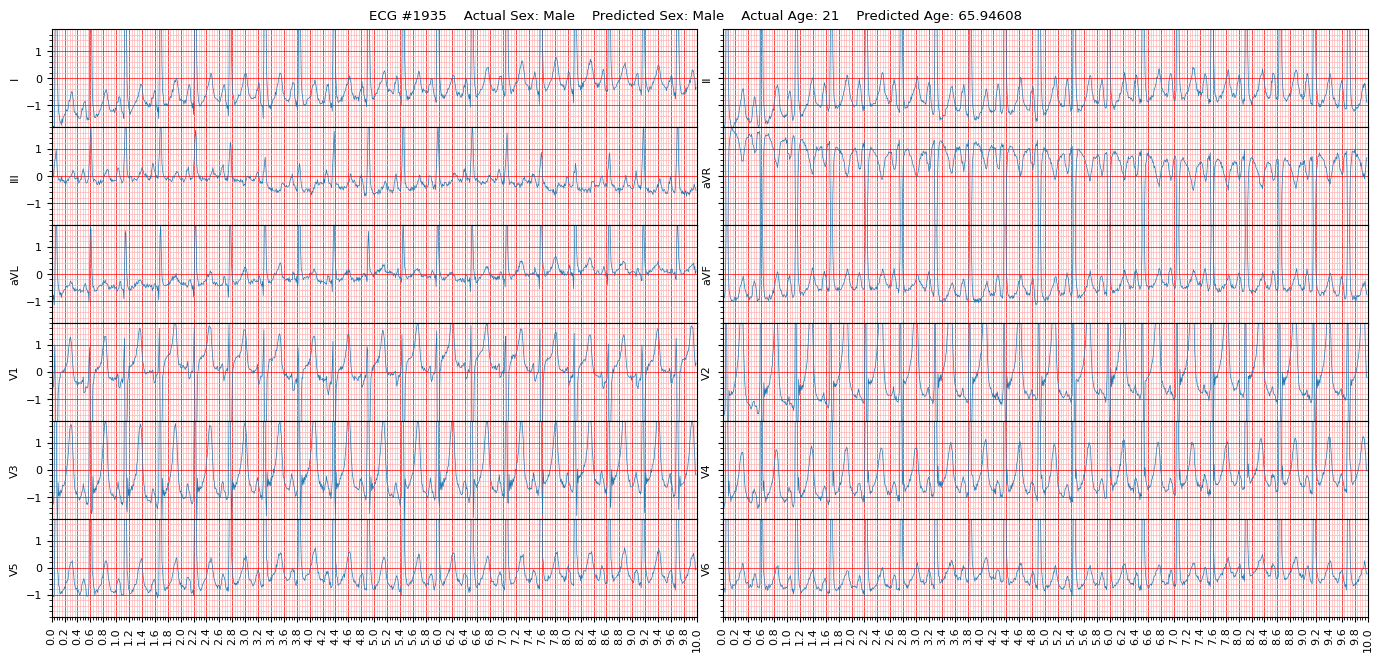

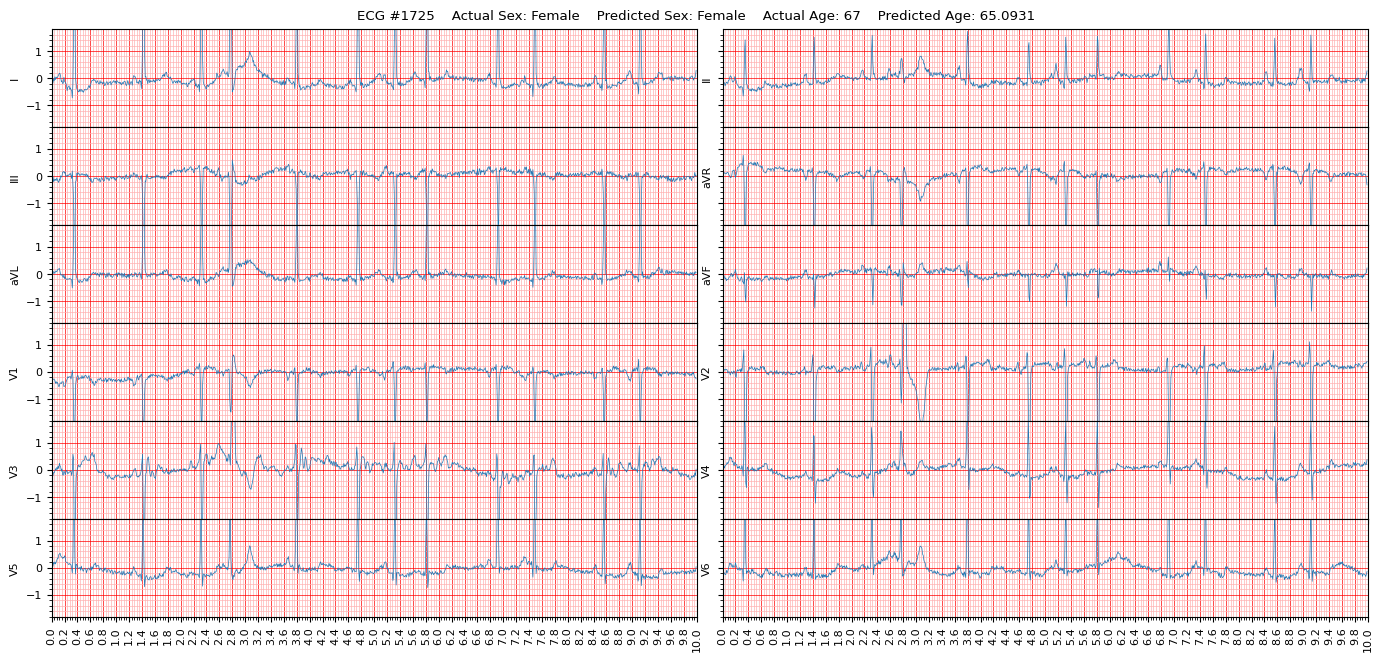

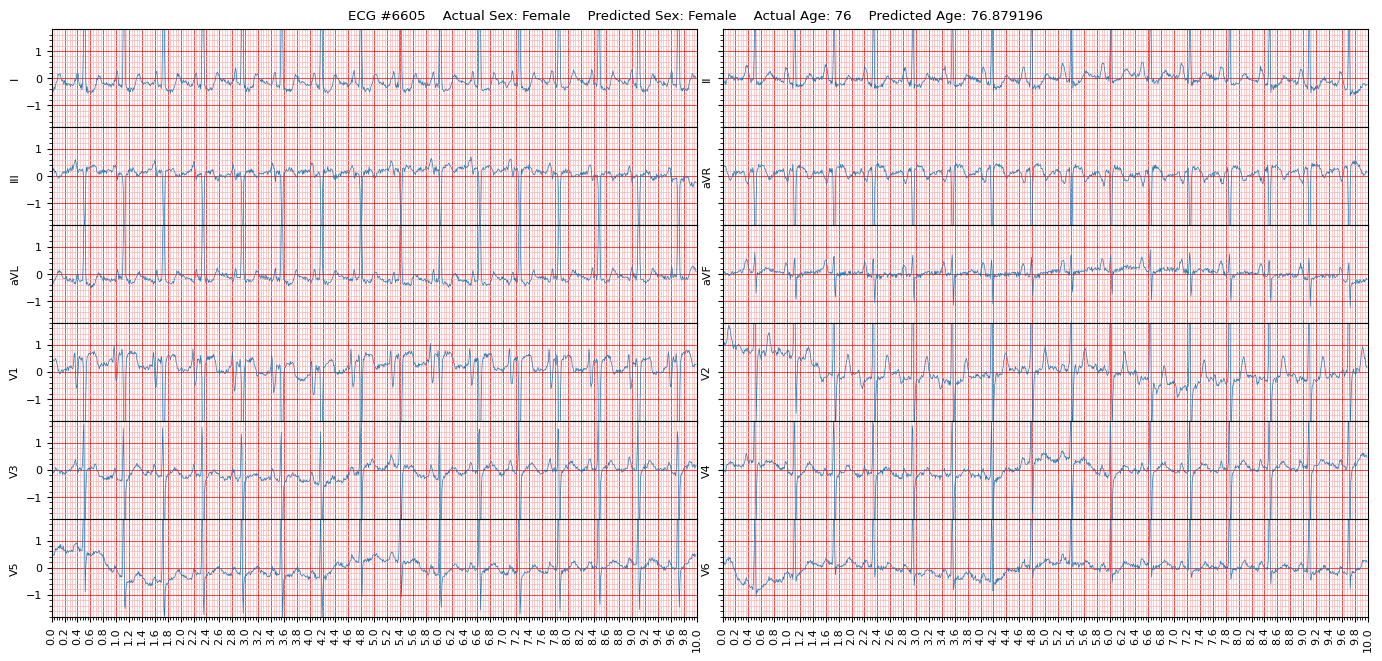

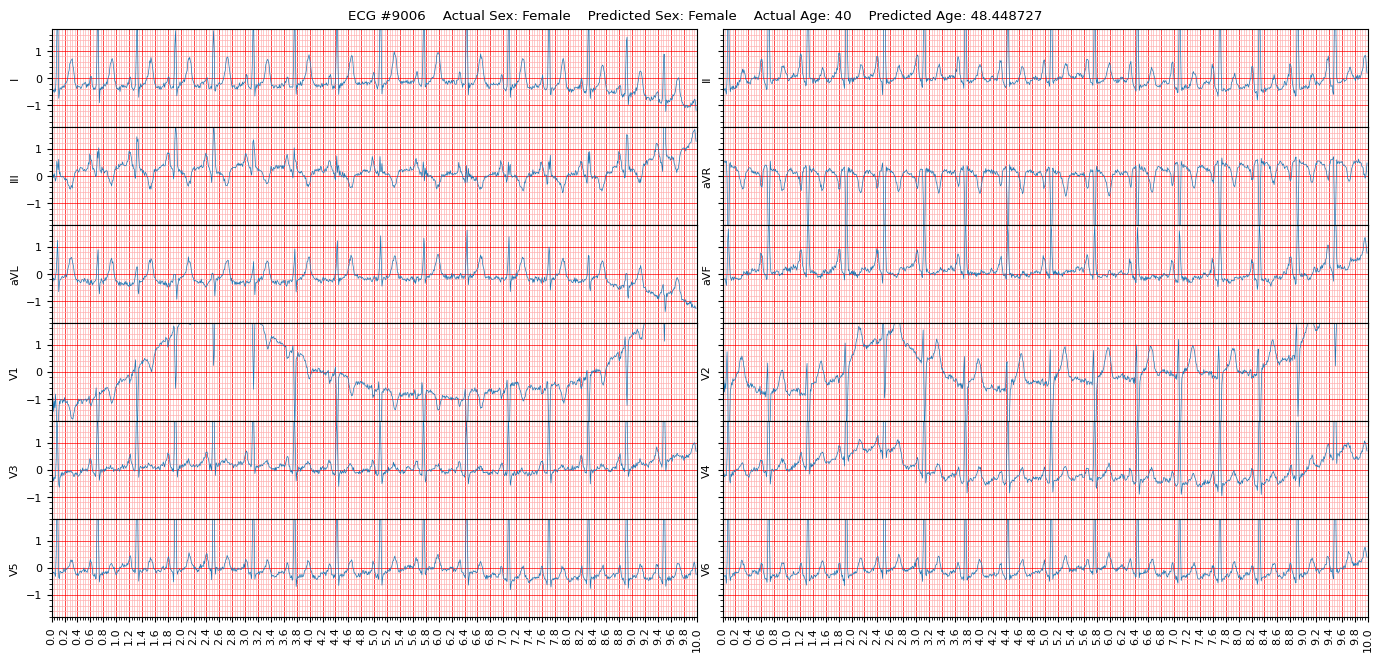

In [43]:
from random import choice

def visualize(X, actual_1, actual_2, predicted_1, predicted_2):
    class_names = ['Male', 'Female']
    for i in range(4):
        ind = choice(range(1, len(X)))
        plot_title = ("ECG #" + str(ind) + "    Actual Sex: " + str(class_names[actual_1[ind]]) + "    Predicted Sex: " + str(class_names[predicted_1[ind]])  +
                      "    Actual Age: " + str(actual_2[ind]) + "    Predicted Age: " + str(predicted_2[ind]))
        ecg_plot.plot_12(tf.transpose(X, (0,2,1))[ind], sample_rate=100, title = plot_title)

with tf.device("/CPU:0"):
    visualize(X_final, actual_sex, actual_ages, combined_sex_preds, predicted_age)